## 9.1 Installation and Setup (Colab)

In [ ]:
!git clone https://github.com/opendp/smartnoise-sdk

In [ ]:
cd smartnoise-sdk/synth

In [ ]:
!python setup.py build

In [ ]:
!python setup.py install

In [ ]:
!pip install opacus

In [ ]:
! pip install diffprivlib

In [ ]:
! pip install themis_ml

In [ ]:
!pip install threadpoolctl

In [ ]:
!pip install ctgan==0.4.3

In [1]:
import numpy as np
import pandas as pd
import time
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from diffprivlib.models import LogisticRegression as DPLR
from sklearn.metrics import classification_report
from snsynth.mwem import MWEMSynthesizer

import warnings
from snsynth import QUAILSynthesizer
from snsynth.pytorch import PytorchDPSynthesizer
from snsynth.pytorch.nn import DPCTGAN
from snsynth.pytorch.nn import PATECTGAN
warnings.filterwarnings("ignore")

In [2]:
def preprocessGermanCredit(temp_df):
    """
    Preprocess German Credit dataset

    credit_risk                                            int64
    duration_in_month                                      int64
    credit_amount                                          int64
    installment_rate_in_percentage_of_disposable_income    int64
    age                                                    int64
    credit_history                                         int64
    housing                                                int64
    status_of_existing_checking_account                    int64
    present_employment_since                               int64
    purpose                                                int64
    dtype: object
    """
    df = temp_df.copy()
    
    df['credit_amount'] /= 500
    df['credit_amount'] = df['credit_amount'].astype(int)
    df.loc[df['age_in_years'] <= 25, 'age'] = 1 
    df.loc[df['age_in_years'] > 25, 'age'] = 0
    df['age'] = df['age'].astype(int)
    # categorical_features 
    housing = {2: 'for free', 1: 'own',  0: 'rent'}
    credit_history = {0: 'no_credits_taken/all_credits_paid_back_duly', 
                        1: 'all_credits_at_this_bank_paid_back_duly',
                        2: 'existing_credits_paid_back_duly_till_now', 
                        3: 'delay_in_paying_off_in_the_past',
                        4: 'critical_account/other_credits_existing_not_at_this_bank',
                    }
    
    df["credit_history"] = df["credit_history"].map({v: k for k, v in credit_history.items()})
    df["housing"] = df["housing"].map({v: k for k,v in housing.items()})
    df['purpose'] = pd.factorize(df['purpose'])[0]

    df = df[['duration_in_month', 'credit_amount', 'installment_rate_in_percentage_of_disposable_income', 'age', 'credit_history', 'housing','status_of_existing_checking_account','present_employment_since', 'purpose', 'credit_risk']]
    return df

In [3]:
def logisticRegression(x_train, y_train, x_test):
    from sklearn.linear_model import LogisticRegression

    logisticRegr = LogisticRegression(solver='lbfgs', max_iter=500)
    logisticRegr.fit(x_train, y_train)

    train_predictions = logisticRegr.predict(x_train)
    test_predictions = logisticRegr.predict(x_test)
    return train_predictions, test_predictions

In [4]:
def get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target):

    # Instantiate an MWEM synthesizer
    def QuailSynth(epsilon):
      if synthesizer == "MWEM": 
          return MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
                                    splits=[], split_factor=2, max_bin_count=400)
      if synthesizer == "PATECTGAN":
          return PytorchDPSynthesizer(epsilon, PATECTGAN(regularization='dragan'), None)
#           return PytorchDPSynthesizer(epsilon=epsilon, preprocessor=None, gan=PATECTGAN(loss='cross_entropy', batch_size=50))
      if synthesizer == "DPCTGAN":
          return PytorchDPSynthesizer(epsilon, DPCTGAN(), None)
        
    # Instantiate a DPLR classifier
    def QuailClassifier(epsilon):
      return DPLR(epsilon=epsilon)

    # Create a QUAIL synthesizer with base synthesizer and DP classifier
    quail = QUAILSynthesizer(epsilon, QuailSynth, QuailClassifier, target, eps_split) ## none for classifier

    return quail

In [5]:
def predictionSummary(temp_x, y_real, y_predict, df):
    tn, fp, fn, tp = confusion_matrix(y_real, y_predict, labels=[0,1]).ravel()
    # False Positive, False Negative, True Positive, True Negative, Overall Accuracy
    overall = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]
    
    x = temp_x.copy()
    x['Predicted Creditability'] = y_predict
    x['Real Creditability'] = y_real
    x_protected = x[df['age'] == 1].copy()
    tn, fp, fn, tp  = confusion_matrix(x_protected['Real Creditability'], x_protected['Predicted Creditability'], labels=[0,1]).ravel()
    protected = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    x_unprotected = x[df['age'] == 0].copy()
    tn, fp, fn, tp  = confusion_matrix(x_unprotected['Real Creditability'], x_unprotected['Predicted Creditability'], labels=[0,1]).ravel()
    unprotected = [fp/(fp+tn),fn/(fn+tp),tp/(tp+fn),tn/(tn+fp),(tp+tn)/(tp+fp+fn+tn)]

    return overall, unprotected, protected

In [16]:
def synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM"):
    test_all_results, train_all_results = [],[]
    test_results, train_results = [],[]
    label_ratio, protected_ratio, label_ratio_avg, protected_ratio_avg = [],[],[],[]
    table, table00, table01, table10, table11 = [], [], [], [], []
    categorical_features = ['credit_history', 'housing','status_of_existing_checking_account','purpose','credit_risk']
    # Loop through range of epsilon values
    for epsilon in epsilons:
        print(str(epsilon)+": ", end="")
        train_overall, train_unprotected, train_protected = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        test_overall, test_unprotected, test_protected = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        
        label_ratio.append([])
        protected_ratio.append([])
        table.append([])
    
        # Generate synthetic data many times (to average results)
        for i in range(niteration):
            print(str(i), end=", ")
            while True:
              # Generate synthetic training data
              if synthesizer == "MWEM":
                  synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15,
                                        splits=[], split_factor=6, max_bin_count=400) 
                  # learn the distribution of the real data
                  fit = synth.fit(train_data.to_numpy())  
              if synthesizer == "QUAIL":
                  synth = get_quail_synthesizer("MWEM", None, epsilon, None, target="credit_risk")
                  fit = synth.fit(train_data)  
              if synthesizer == "DPCTGAN":
                  synth = PytorchDPSynthesizer(epsilon, DPCTGAN(), None)
                  fit = synth.fit(train_data, categorical_features)
              if synthesizer == "PATECTGAN":
                  synth = PytorchDPSynthesizer(epsilon, PATECTGAN(regularization='dragan'), None)
                  fit = synth.fit(train_data, categorical_features)
              if synthesizer == "PATECTGANQUAIL":
                  synth = get_quail_synthesizer("PATECTGAN", None, epsilon, None, target="credit_risk")
                  fit = synth.fit(train_data, categorical_columns=['credit_history', 'housing','status_of_existing_checking_account','purpose'])
              if synthesizer == "DPCTGANQUAIL":
                  synth = get_quail_synthesizer("DPCTGAN", None, epsilon, None, target="credit_risk")
                  fit = synth.fit(train_data, categorical_columns=['credit_history', 'housing','status_of_existing_checking_account','purpose'])
              
              # generate synthetic train data
              train_synth = pd.DataFrame(synth.sample(train_data.shape[0]), columns=train_data.columns) 
              # Split synthetic training data into X and y
              x_train, y_train = train_synth.drop(["credit_risk", 'age'], axis=1), train_synth["credit_risk"]
                   
              if len(np.unique(y_train)) == 2:
                break
              else:
                print(np.unique(y_train, return_counts=True))

            # Run the binary classification pipeline
            y_train_predict, y_test_predict = logisticRegression(x_train, y_train, x_test)
            # Save results for each i and for each epsilon
            curr_train_overall, curr_train_unprotected, curr_train_protected = predictionSummary(x_train, y_train, y_train_predict, train_synth)
            curr_test_overall, curr_test_unprotected, curr_test_protected = predictionSummary(x_test, y_test, y_test_predict, test_data)
            
            train_overall = [rate1+rate2 for rate1,rate2 in zip(train_overall,curr_train_overall)]
            train_protected = [rate1+rate2 for rate1,rate2 in zip(train_protected,curr_train_protected)]
            train_unprotected = [rate1+rate2 for rate1,rate2 in zip(train_unprotected,curr_train_unprotected)]
            test_overall = [rate1+rate2 for rate1,rate2 in zip(test_overall,curr_test_overall)]
            test_protected = [rate1+rate2 for rate1,rate2 in zip(test_protected,curr_test_protected)]
            test_unprotected = [rate1+rate2 for rate1,rate2 in zip(test_unprotected,curr_test_unprotected)]
            
            if i == 0:
               test_all_results.append([])
               train_all_results.append([])
            test_all_results[-1].append([curr_test_overall, curr_test_unprotected, curr_test_protected])
            train_all_results[-1].append([curr_train_overall, curr_train_unprotected, curr_train_protected])
            
            # calcualte unprotected ratio and label ratio
            label_ratio[-1].append( (train_synth['credit_risk']==1).sum()/train_synth.shape[0] )
            protected_ratio[-1].append( (train_synth['age']==1).sum()/train_synth.shape[0] )
            
            # calculate protected, not labelled [0][0] & protected, labelled [0][1]
            #           unprotected, not labelled [1][0] & unprotected, labelled  [1][1] ratio
            cm = pd.crosstab(train_synth['age'], train_synth['credit_risk'], rownames=['age'], colnames=['Credit Risk'])
            cm = cm/(train_synth.shape[0])
            table[-1].append(cm)
        
        print()
        train_overall = [rate/niteration for rate in train_overall]
        train_unprotected = [rate/niteration for rate in train_unprotected]
        train_protected = [rate/niteration for rate in train_protected]
        train_results.append([train_overall,train_unprotected,train_protected])
        test_overall = [rate/niteration for rate in test_overall]
        test_unprotected = [rate/niteration for rate in test_unprotected]
        test_protected = [rate/niteration for rate in test_protected]
        test_results.append([test_overall,test_unprotected,test_protected])
        
        label_ratio_avg.append(sum(label_ratio[-1])/niteration)
        protected_ratio_avg.append(sum(protected_ratio[-1])/niteration)   


        list00, list01, list10, list11 = [],[],[],[]
        for t in table[-1]:
          if 0 in t and 0 in t[0]:
            list00.append(t[0][0])
          if 0 in t and 1 in t[0]:
            list01.append(t[0][1])
          if 1 in t and 0 in t[1]:
            list10.append(t[1][0])
          if 1 in t and 1 in t[1]:
            list11.append(t[1][1])
        
        table00.append( sum(list00)/niteration )
        table01.append( sum(list01)/niteration )
        table10.append( sum(list10)/niteration )
        table11.append( sum(list11)/niteration )
    
    ratio_results = {"label_ratio": label_ratio, "protected_ratio": protected_ratio, 
                     "label_ratio_avg": label_ratio_avg,"protected_ratio_avg": protected_ratio_avg, "table": table,
                    "table00": table00, "table01": table01, "table10": table10, "table11": table11}

    return {"avg_results": {"test_results": test_results, "train_results": train_results}, 
            "all_results": {"test_all_results": test_all_results, "train_all_results": train_all_results, }, "ratio_results": ratio_results}

In [7]:
def plotAccuracy(synthesizer, test_results, train_results, epsilons):
  plt.plot(epsilons,[result[0][4] for result in test_results],label="testing",color="r",marker="o")
  plt.plot(epsilons,[result[0][4] for result in train_results],label="training",color="b",marker="o")
  plt.hlines(0.685,xmin=min(epsilons), xmax=max(epsilons),label="non-private testing",linestyles="--",color="r")
  plt.hlines(0.73375,xmin=min(epsilons), xmax=max(epsilons),label="non-private training",linestyles="--",color="b")

  plt.legend()
  plt.title(synthesizer +": Accuracy versus epsilons")
  plt.ylabel("Accuracy")
  plt.xlabel("Epsilon")

In [8]:
def plotEqualizedOdds(synthesizer, test_results, train_results, epsilons, ylim=(-0.02,0.25)):
  f = plt.figure(figsize=(16,6))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)
  plt.suptitle(synthesizer + ": Equalized odds distances versus epsilons")

  # protected TPR - unprotected TPR
  ax.plot(epsilons,[result[1][2]-result[2][2] for result in test_results],label="testing TPR diff",marker="o")
  ax.plot(epsilons,[result[1][2]-result[2][2] for result in train_results],label="training TPR diff",marker="o")
  ax.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
  ax.hlines(0.1057377049180327,xmin=min(epsilons), xmax=max(epsilons),label="non-private TPR diff",linestyles="--",color="red")
  ax.legend()
  ax.set_xlabel("Epsilon")
  ax.set_ylabel("Equalized odds distance")
  ax.set_ylim(ylim[0],ylim[1])
  ax.set_title(synthesizer + ": (TPR) Equalized odds distances versus epsilons")

  # protected FPR - unprotected FPR
  ax2.plot(epsilons,[result[1][0]-result[2][0] for result in test_results],label="testing FPR diff",marker="o")
  ax2.plot(epsilons,[result[1][0]-result[2][0] for result in train_results],label="training FPR diff",marker="o")
  ax2.hlines(0,xmin=min(epsilons), xmax=max(epsilons),label="perfect fairness",linestyles="--")
  ax2.hlines(0.05277777777777781,xmin=min(epsilons), xmax=max(epsilons),label="non-private FPR diff",linestyles="--",color="red")
  
  ax2.legend()
  ax2.set_xlabel("Epsilon")
  ax2.set_ylabel("Equalized odds distance")
  ax2.set_ylim(ylim[0],ylim[1])
  ax2.set_title(synthesizer + ": (FPT) Equalized odds distances versus epsilons")

In [22]:
from themis_ml.datasets import german_credit
credit = german_credit(raw=True)

In [23]:
df = preprocessGermanCredit(credit)
df.shape

(1000, 10)

## 9.2 MWEM

In [24]:
# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)

# Split test data into X and y
x_test, y_test = test_data.drop(["credit_risk", 'age'], axis=1), test_data["credit_risk"]
epsilons = np.linspace(1,8,8) # get slow after >=7

In [ ]:
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("German_fairness_mwem.npy", allow_pickle=True).item()
    avg_results, all_results, ratio_results = results_dict["avg_results"], results_dict["all_results"], results_dict["ratio_results"]
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="MWEM")
    np.save("German_fairness_mwem.npy", results_dict) 

print(results_dict)

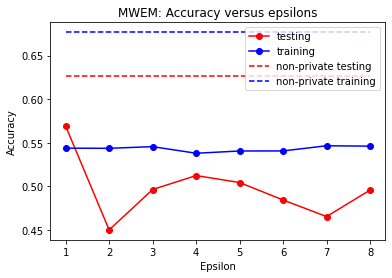

In [ ]:
plotAccuracy("MWEM", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons)

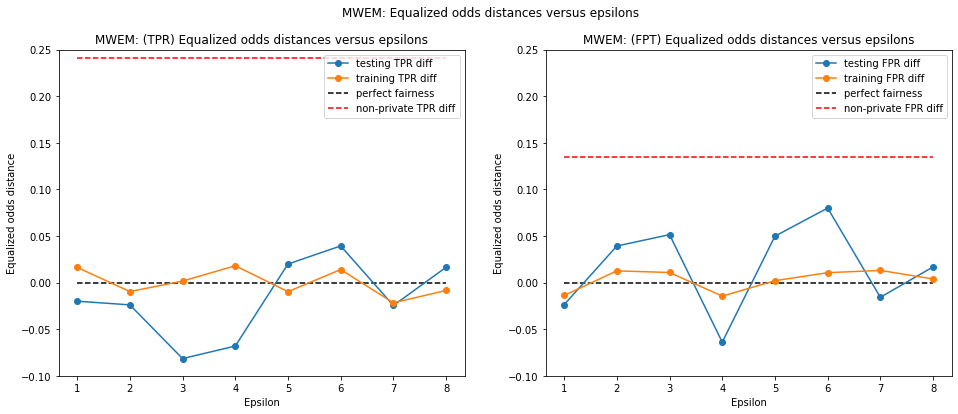

In [ ]:
plotEqualizedOdds("MWEM", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons, ylim=(-0.10,0.25))

## 9.3 MWEM + QUAIL

In [ ]:
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("German_fairness_quail.npy", allow_pickle=True).item()
    avg_results, all_results, ratio_results = results_dict["avg_results"], results_dict["all_results"], results_dict["ratio_results"]
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="QUAIL")
    np.save("German_fairness_quail.npy", results_dict) 

print(results_dict)

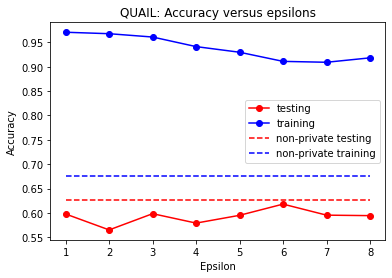

In [ ]:
plotAccuracy("QUAIL", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons)

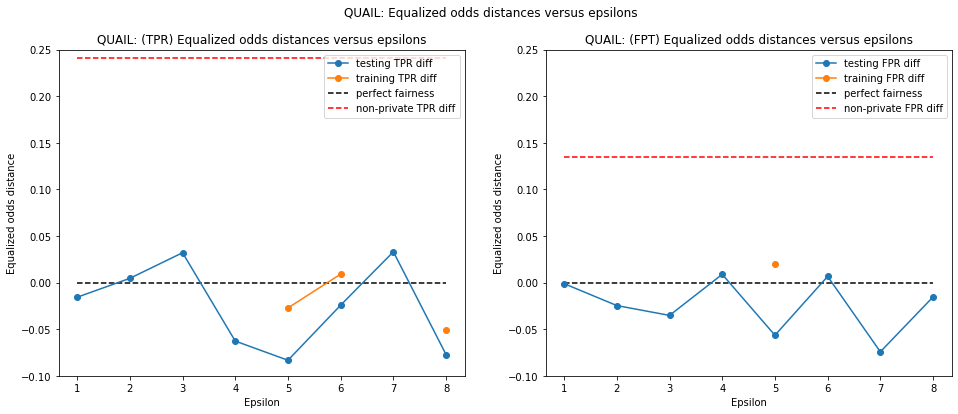

In [ ]:
plotEqualizedOdds("QUAIL", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons, ylim=(-0.10,0.25))

## 9.4 DPCTGAN

In [ ]:
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("German_fairness_DPCTGAN.npy", allow_pickle=True).item()
    avg_results, all_results, ratio_results = results_dict["avg_results"], results_dict["all_results"], results_dict["ratio_results"]
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="DPCTGAN")
    np.save("German_fairness_DPCTGAN.npy", results_dict) 

print(results_dict)

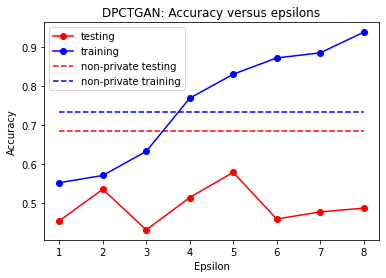

In [ ]:
plotAccuracy("DPCTGAN", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons)

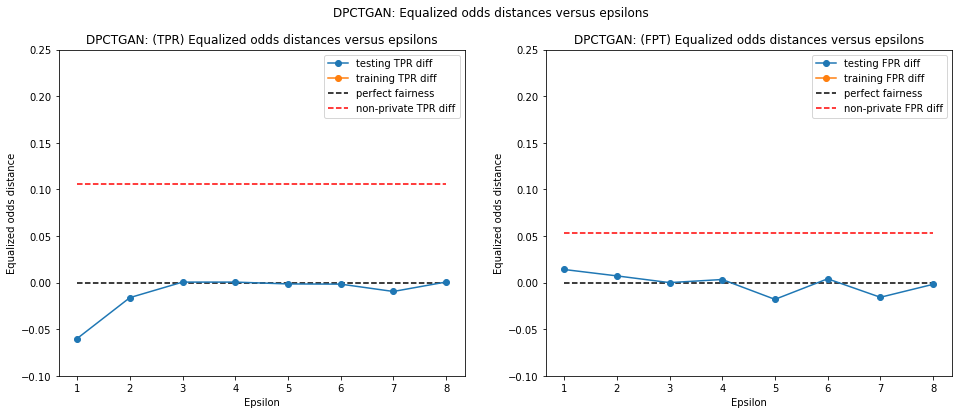

In [ ]:
plotEqualizedOdds("DPCTGAN", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons, ylim=(-0.10,0.25))

## 9.5 PATECTGAN

In [ ]:
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("German_fairness_PATECTGAN.npy", allow_pickle=True).item()
    avg_results, all_results, ratio_results = results_dict["avg_results"], results_dict["all_results"], results_dict["ratio_results"]
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="PATECTGAN")
    np.save("German_fairness_PATECTGAN.npy", results_dict) 

print(results_dict)

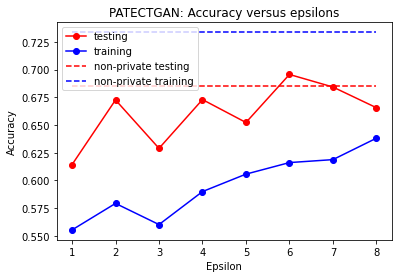

In [25]:
plotAccuracy("PATECTGAN", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons)

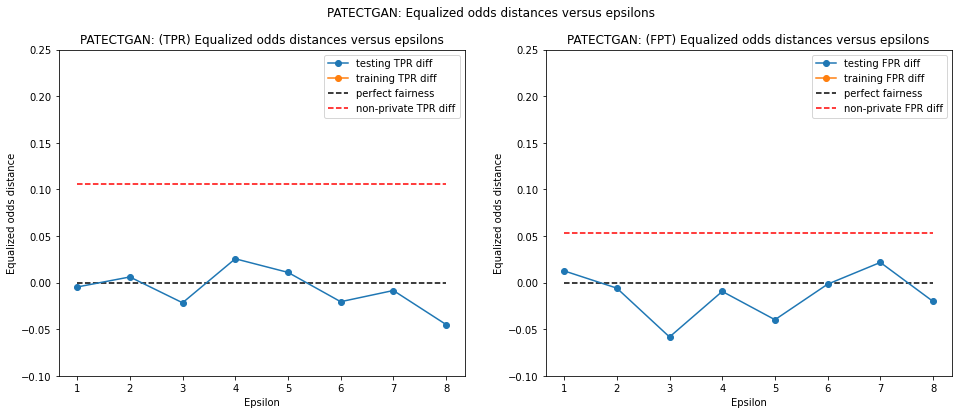

In [26]:
plotEqualizedOdds("PATECTGAN", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons, ylim=(-0.10,0.25))

## 9.6 DPCTGAN + QUAIL

In [ ]:
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("German_fairness_DPCTGANQUAIL.npy", allow_pickle = True).item()
    avg_results, all_results, ratio_results = results_dict["avg_results"], results_dict["all_results"], results_dict["ratio_results"]
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="DPCTGANQUAIL")
    np.save("German_fairness_DPCTGANQUAIL.npy", results_dict) 

print(results_dict)

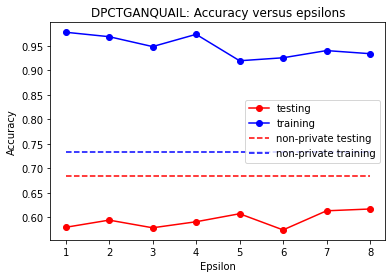

In [21]:
plotAccuracy("DPCTGANQUAIL", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons)

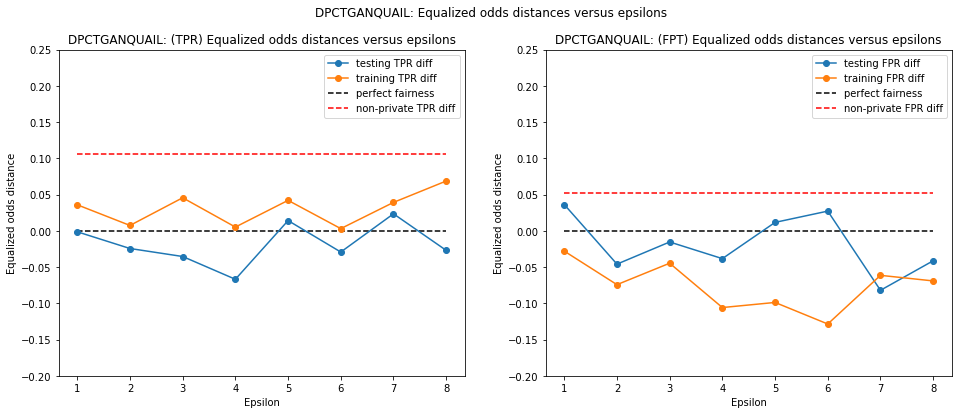

In [20]:
plotEqualizedOdds("DPCTGANQUAIL", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons, ylim=(-0.20,0.25))

## 9.7 PATECTGAN + QUAIL

In [26]:
epsilons = np.linspace(2,10,9) # get slow after >=7

In [ ]:
try:
    # Try to load the dictionary with ten repetitions
    results_dict = np.load("German_fairness_PATECTGANQUAIL.npy", allow_pickle=True).item()
    avg_results, all_results, ratio_results = results_dict["avg_results"], results_dict["all_results"], results_dict["ratio_results"]
except: 
    results_dict = synthesizer(train_data, test_data, x_test, y_test, epsilons, niteration = 15, synthesizer="PATECTGANQUAIL")
    np.save("German_fairness_PATECTGANQUAIL.npy", results_dict) 

print(results_dict)

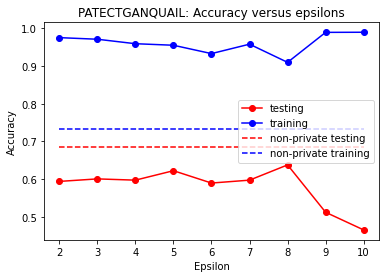

In [28]:
plotAccuracy("PATECTGANQUAIL", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons)

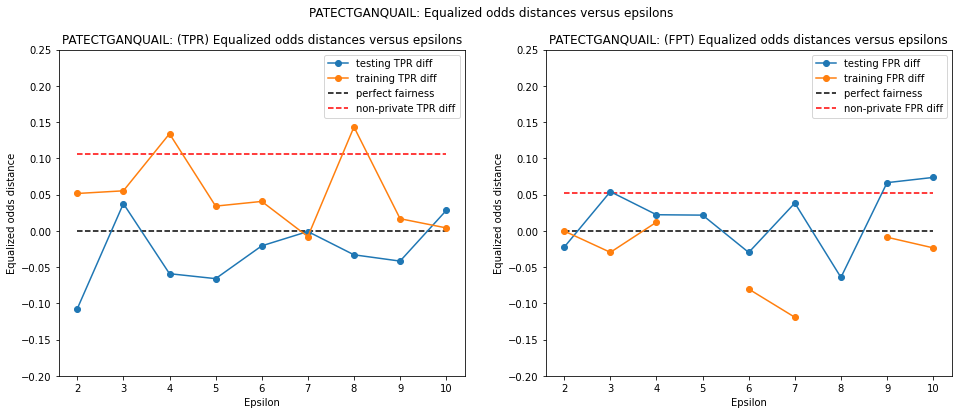

In [29]:
plotEqualizedOdds("PATECTGANQUAIL", results_dict["avg_results"]["test_results"], results_dict["avg_results"]["train_results"], epsilons, ylim=(-0.20,0.25))